# Risk Analysis for Sri Lanka Tourism — Forecast Year 2025

This notebook evaluates **downside and upside risks** to Sri Lanka's **tourism revenue** in **2025** using the historical dataset (2015–2024).
We combine:
- **Scenario analysis** (Pessimistic, Baseline, Optimistic)
- **Monte Carlo simulation** (uncertainty in arrivals, average stay, and daily spend)
- **Sensitivity analysis** using an OLS regression (which drivers matter most)
- **Visualizations** and **conclusions** with policy-oriented **precautions**

> **Data required:** `data/raw/tourism_data.csv` with columns  
`year,month,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend`


## 1) Setup & Data Loading

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Try common repo-relative paths
paths = [Path('../data/raw/tourism_data.csv'), Path('./data/raw/tourism_data.csv'), Path('data/raw/tourism_data.csv')]
csv_path = None
for p in paths:
    if p.exists():
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'tourism_data.csv'. Please place it in data/raw/ and re-run.")

df = pd.read_csv(csv_path)
# Create a monthly date index
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')
df = df.sort_values('date').reset_index(drop=True)

# Quick sanity check
display(df.head())
print("Data range:", df['date'].min().date(), "to", df['date'].max().date())


,year,month,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend,date
0,2015,1,155000,255000000,10.0,165,2015-01-01
1,2015,2,160000,265000000,10.0,165,2015-02-01
2,2015,3,170000,280000000,10.2,166,2015-03-01
3,2015,4,140000,230000000,9.8,164,2015-04-01
4,2015,5,130000,210000000,9.5,163,2015-05-01


Data range: 2015-01-01 to 2024-12-01


## 2) Feature Preparation

In [2]:

# Ensure numeric dtypes
for col in ['tourist_arrivals','tourism_revenue_usd','avg_stay','avg_daily_spend']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Extract the latest full year (2024) as baseline for 2025
base_2024 = df[df['year'] == 2024].copy()
if base_2024.empty or base_2024.shape[0] < 12:
    raise ValueError("Expected 12 months for 2024 as the baseline for 2025. Please verify the dataset.")

base_2024 = base_2024.sort_values('month').reset_index(drop=True)
base_2024['date_2025'] = base_2024['date'] + pd.DateOffset(years=1)

# We'll model revenue = arrivals * avg_stay * avg_daily_spend under stochastic shocks
base_2024 = base_2024[['month','tourist_arrivals','avg_stay','avg_daily_spend','date_2025']]
display(base_2024.head())


,month,tourist_arrivals,avg_stay,avg_daily_spend,date_2025
0,1,208000,9.3,145,2025-01-01
1,2,218000,9.4,145,2025-02-01
2,3,209000,9.4,145,2025-03-01
3,4,149000,8.7,140,2025-04-01
4,5,112000,8.2,138,2025-05-01


## 3) Scenario Design

We construct three **high-level scenarios** for 2025 and then embed **uncertainty** via Monte Carlo:

- **Pessimistic**: Softer global demand / shocks to travel  
  - Arrivals mean drift: **-8%**
  - Average stay drift: **-2%**
  - Daily spend drift: **-5%**

- **Baseline**: Continuation of 2024 patterns (no drift)  
  - Arrivals mean drift: **0%**
  - Average stay drift: **0%**
  - Daily spend drift: **0%**

- **Optimistic**: Strong demand & successful tourism initiatives  
  - Arrivals mean drift: **+8%**
  - Average stay drift: **+2%**
  - Daily spend drift: **+5%**

**Uncertainty (standard deviations)** applied multiplicatively each month:
- Arrivals **±10%**, Avg stay **±3%**, Daily spend **±5%**.

> All shocks are drawn from normal distributions and applied multiplicatively (truncated to avoid negative values).


## 4) Monte Carlo Simulation of 2025 Revenue

In [3]:

rng = np.random.default_rng(42)

def simulate_year(baseline_df, drift_arr=0.0, drift_stay=0.0, drift_spend=0.0, 
                  sd_arr=0.10, sd_stay=0.03, sd_spend=0.05, n_sims=10000):
    # Arrays for baseline
    arr = baseline_df['tourist_arrivals'].values.astype(float)
    stay = baseline_df['avg_stay'].values.astype(float)
    spend = baseline_df['avg_daily_spend'].values.astype(float)
    
    # Apply mean drift multiplicatively
    arr_mean = arr * (1 + drift_arr)
    stay_mean = stay * (1 + drift_stay)
    spend_mean = spend * (1 + drift_spend)
    
    # Draw shocks
    arr_shock = rng.normal(1.0, sd_arr, size=(n_sims, len(arr)))
    stay_shock = rng.normal(1.0, sd_stay, size=(n_sims, len(stay)))
    spend_shock = rng.normal(1.0, sd_spend, size=(n_sims, len(spend)))
    
    # Truncate to avoid negatives
    arr_shock = np.clip(arr_shock, 0.5, 1.5)
    stay_shock = np.clip(stay_shock, 0.7, 1.3)
    spend_shock = np.clip(spend_shock, 0.7, 1.3)
    
    # Simulated monthly values
    sim_arr = arr_mean * arr_shock
    sim_stay = stay_mean * stay_shock
    sim_spend = spend_mean * spend_shock
    
    # Revenue per month and annual
    sim_month_rev = sim_arr * sim_stay * sim_spend
    sim_annual_rev = sim_month_rev.sum(axis=1)
    return sim_annual_rev, sim_month_rev

scenarios = {
    "Pessimistic": {"drift_arr":-0.08, "drift_stay":-0.02, "drift_spend":-0.05},
    "Baseline":    {"drift_arr": 0.00, "drift_stay": 0.00, "drift_spend": 0.00},
    "Optimistic":  {"drift_arr": 0.08, "drift_stay": 0.02, "drift_spend": 0.05},
}

results = {}
for name, params in scenarios.items():
    total, monthly = simulate_year(base_2024, **params, n_sims=10000)
    results[name] = {"annual": total, "monthly": monthly}

# Summary statistics
summary = []
for name, res in results.items():
    annual = res["annual"]
    summary.append({
        "Scenario": name,
        "Mean_Annual_Revenue_USD": annual.mean(),
        "P10": np.percentile(annual, 10),
        "P50": np.percentile(annual, 50),
        "P90": np.percentile(annual, 90),
        "VaR_5pct": np.percentile(annual, 5),
        "CVaR_5pct": annual[annual <= np.percentile(annual, 5)].mean()
    })
summary_df = pd.DataFrame(summary).sort_values("Scenario")
summary_df


,Scenario,Mean_Annual_Revenue_USD,P10,P50,P90,VaR_5pct,CVaR_5pct
1,Baseline,2.665797e+09,2.546130e+09,2.665363e+09,2.785705e+09,2.511072e+09,2.474868e+09
2,Optimistic,3.085758e+09,2.947121e+09,3.084405e+09,3.225148e+09,2.908402e+09,2.867204e+09
0,Pessimistic,2.283030e+09,2.180524e+09,2.283006e+09,2.384922e+09,2.153138e+09,2.122887e+09


## 5) Visualizations — Annual Revenue Distribution (2025)

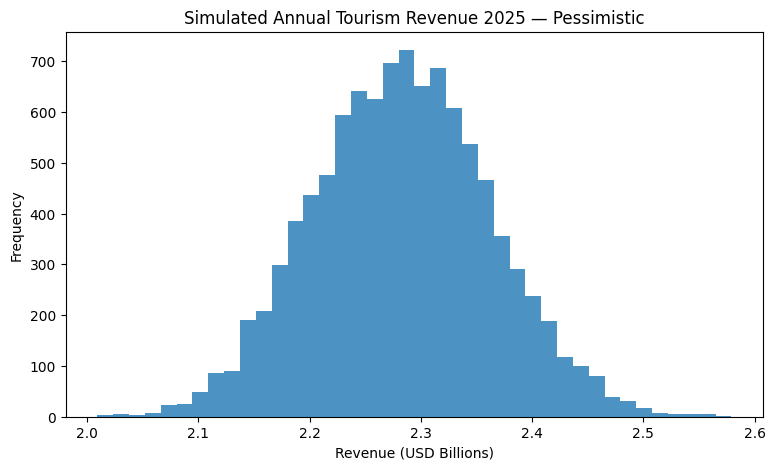

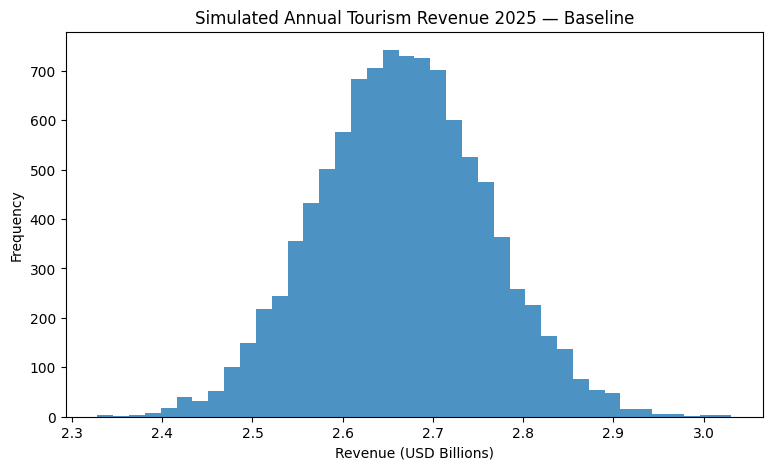

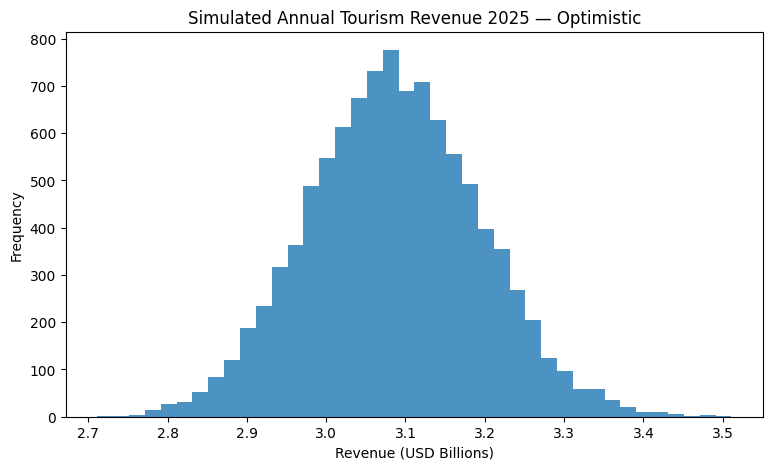

In [4]:

# Histogram per scenario (separate figures to comply with single-plot rule)
for name, res in results.items():
    plt.figure(figsize=(9,5))
    plt.hist(res["annual"]/1e9, bins=40, alpha=0.8)
    plt.title(f"Simulated Annual Tourism Revenue 2025 — {name}")
    plt.xlabel("Revenue (USD Billions)")
    plt.ylabel("Frequency")
    plt.show()


## 6) Sensitivity Analysis — Which Drivers Matter Most?

We fit an **OLS regression** on 2015–2024 to approximate how strongly each driver explains revenue.
We then interpret standardized coefficients to gauge **relative importance**.


In [5]:

import statsmodels.api as sm

hist = df[(df['year'] >= 2015) & (df['year'] <= 2024)].copy()

# Prepare features and target
X = hist[['tourist_arrivals','avg_stay','avg_daily_spend']].copy()
y = hist['tourism_revenue_usd'].copy()

# Standardize features for comparability of coefficients
X_std = (X - X.mean()) / X.std(ddof=0)
X_std = sm.add_constant(X_std)
model = sm.OLS(y, X_std).fit()
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     tourism_revenue_usd   R-squared:                       0.938
Model:                             OLS   Adj. R-squared:                  0.937
Method:                  Least Squares   F-statistic:                     589.6
Date:                 Wed, 03 Sep 2025   Prob (F-statistic):           4.95e-70
Time:                         22:44:54   Log-Likelihood:                -2271.3
No. Observations:                  120   AIC:                             4551.
Df Residuals:                      116   BIC:                             4562.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              2.87e+08   

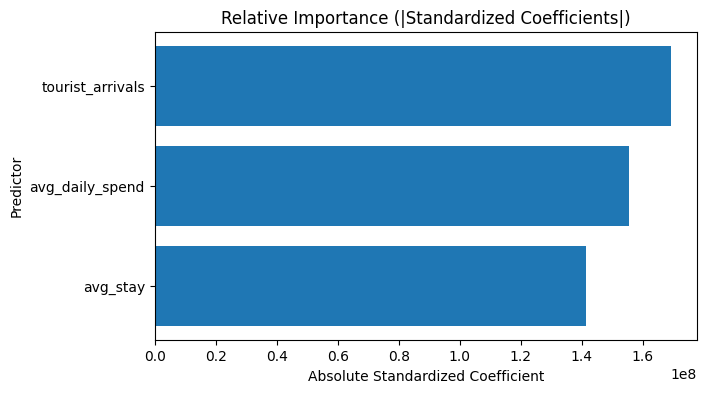

In [6]:

coefs = model.params.drop('const')
imp = coefs.abs().sort_values(ascending=True)

plt.figure(figsize=(7,4))
plt.barh(imp.index, imp.values)
plt.title("Relative Importance (|Standardized Coefficients|)")
plt.xlabel("Absolute Standardized Coefficient")
plt.ylabel("Predictor")
plt.show()


## 7) Scenario Summary & Interpretation

In [7]:

# Present scenario summary in a readable table (billions)
table = summary_df.copy()
for c in ["Mean_Annual_Revenue_USD","P10","P50","P90","VaR_5pct","CVaR_5pct"]:
    table[c] = table[c] / 1e9
table = table.rename(columns={
    "Mean_Annual_Revenue_USD":"Mean (USD Bn)",
    "P10":"P10 (USD Bn)",
    "P50":"Median (USD Bn)",
    "P90":"P90 (USD Bn)",
    "VaR_5pct":"VaR 5% (USD Bn)",
    "CVaR_5pct":"CVaR 5% (USD Bn)"
}).sort_values("Scenario")
table


,Scenario,Mean (USD Bn),P10 (USD Bn),Median (USD Bn),P90 (USD Bn),VaR 5% (USD Bn),CVaR 5% (USD Bn)
1,Baseline,2.665797,2.546130,2.665363,2.785705,2.511072,2.474868
2,Optimistic,3.085758,2.947121,3.084405,3.225148,2.908402,2.867204
0,Pessimistic,2.283030,2.180524,2.283006,2.384922,2.153138,2.122887


## 8) Economic Implications (Qualitative)

Tourism is a key foreign-earnings channel. Changes in tourism revenue can ripple through:
- **Foreign exchange inflows:** Lower revenue worsens FX supply, potentially pressuring the currency and import capacity.
- **Employment & SMEs:** Hotels, transport, guides, restaurants, and informal sector incomes are sensitive to arrivals.
- **Government revenues:** VAT, service charges, and sector taxes co-move with activity.
- **Investment sentiment:** Sustained downturns can delay private investment in accommodation and attractions.

**Interpreting the scenarios:**
- **Pessimistic:** FX inflows weaken; risk of tighter external balances. SMEs face cashflow stress; government revenues soften.
- **Baseline:** Stable conditions; manageable external and fiscal impact.
- **Optimistic:** Strong inflows; improved FX buffers and fiscal space; room to invest in infrastructure and marketing.

> Use the scenario table to discuss ranges rather than single-point forecasts.


## 9) Policy Precautions & Mitigations

1. **Market Diversification:** Reduce concentration risk by targeting multiple source markets and segments (culture, wellness, eco, MICE).
2. **Visa & ETA Facilitation:** Streamlined entry (e-visa/ETA) and on-arrival clarity to prevent friction in peak seasons.
3. **Price-Value Balance:** Encourage transparent, competitive pricing to protect spend-per-visitor without deterring demand.
4. **Experience & Safety Signals:** Reliable transport, clean sites, and safety communications to sustain confidence.
5. **SME Support & Working Capital:** Targeted credit lines / guarantees for high-season prep; promote digital bookings.
6. **Resilient Infrastructure:** Address choke points (air connectivity, last-mile transport, energy/water at hotspots).
7. **Data & Early Warning:** Monthly dashboards; track bookings, search trends, and cancellations to trigger timely responses.
8. **FX Risk Management:** Encourage sector hedging practices for large operators; promote local supply linkages to reduce import leakage.


## 10) Conclusions

- **Risk ranges**: The distributions show plausible upside and downside around 2025 revenue.
- **Key drivers**: Regression sensitivity indicates which levers (arrivals, stay, spend) most affect outcomes.
- **Actionability**: Policies that raise **spend-per-visitor** and **length-of-stay** can amplify revenue without over-relying on volumes.
- **Next steps**: Stress-test additional shocks (energy price spikes, global slowdown), incorporate external indicators (exchange rates, flight capacity), and update scenarios quarterly with fresh data.
